In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_probability as tfp

import corner 
import math as m
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm

from HessianMCMC import HessianMCMC
from Grav_polygon import constant64,Gravity_Polygon
from GaussianProcess import GaussianProcess2Dlayer
from matplotlib.colors import from_levels_and_colors
tfb = tfp.bijectors
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

#### Z direction gravity line integration following Won 1987
\begin{equation}
\Delta g_{z}=2 G \rho \sum_{i=1}^{n} Z_{i}
\end{equation}

\begin{equation}
Z=A\left[\left(\theta_{1}-\theta_{2}\right)+B \ln \frac{r_{2}}{r_{1}}\right]
\end{equation}

where,   
\begin{equation}
\begin{aligned}
&A=\frac{\left(x_{2}-x_{1}\right)\left(x_{1} z_{2}-x_{2} z_{1}\right)}{\left(x_{2}-x_{1}\right)^{2}+\left(z_{2}-z_{1}\right)^{2}}\\
&B=\frac{z_{2}-z_{1}}{x_{2}-x_{1}}
\end{aligned}
\end{equation}

and,   
\begin{equation}
\begin{aligned}
&r_{1}^{2}=x_{1}^{2}+z_{1}^{2}\\
&r_{2}^{2}=x_{2}^{2}+z_{2}^{2}
\end{aligned}
\end{equation}


In [44]:
## define some numbers
Number_para = 5
obs_N = 25
number_burnin = 3000
number_sample = 10000
steps_gradient_decent = 2000

pi = constant64(m.pi) # define PI in Tensorflow form

depth = constant64(-100)
thickness = constant64(30)

Range = constant64([-200.,200.])

In [45]:
# prior
mu_prior = -50.*tf.ones([Number_para],dtype = tf.float64)
cov_prior = 15.*tf.eye(Number_para,dtype = tf.float64)

x_obv = tf.linspace(Range[0],Range[1],obs_N)

rho = 2000
# likelihood
sig_e = constant64(2*1e-8)
cov = sig_e**2.*tf.eye(obs_N,dtype = tf.float64)

In [46]:
model = Gravity_Polygon(obs_N,Range,rho,thickness,Number_para)

In [47]:
model.set_prior(mu_prior,cov_prior,cov)

In [48]:
model.depth = depth

## Define the ground truth

In [49]:
tf.random.set_seed(8)

# X- values: uniformly distributed
control_index = tf.linspace(Range[0],Range[1],Number_para)
# control_index with non-even distribution
# control_index = tf.linspace(Range[0],Range[1],Number_para)+tf.random.uniform([Number_para],-20,20,dtype = tf.float64)

## define the true z-values

True_position_sin = 20*tf.sin(0.01*control_index)+depth
gp = GaussianProcess2Dlayer(Range,depth,Number_para,thickness,)
x_true,z_true =gp.GaussianProcess(control_index,True_position_sin)

In [50]:
gp.amplitude =tfp.util.TransformedVariable(0.015, tfb.Exp(), dtype=tf.float64, name='amplitude')
gp.length_scale = tfp.util.TransformedVariable(
            100, tfb.Exp(), dtype=tf.float64, name='length_scale')
gp.kernel = psd_kernels.ExponentiatedQuadratic(
    gp.amplitude, gp.length_scale)
gp.observation_noise_variance = 0.

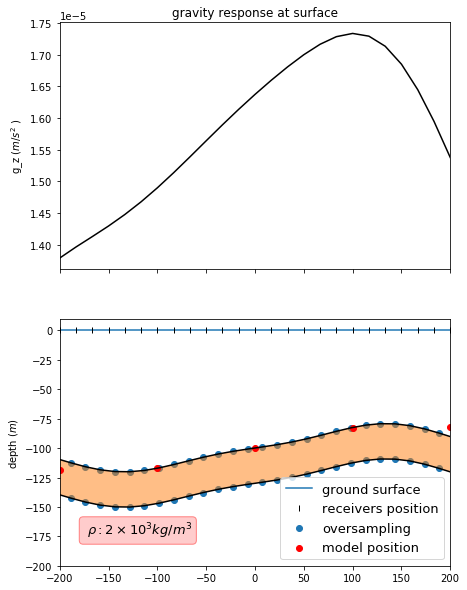

In [58]:
def simulated_gravity(x,z,x_obs=None,Number_=obs_N ,R=100,ax = None,style = None,**kwargs):
    """
    kwargs:
        x_obs: x coordinates of observation points
        Number_: number of observation points, if x_obs is not given
    return: 
        gravity: Tensor
    """
    if ax is None:
        f,ax=plt.subplots()
    if x_obs is None:
        x_obs = np.linspace(-R,R,Number_)
    y = np.zeros(np.shape(x_obs))
    obv = np.vstack((x_obs,y)).T

    gravity = model.calculate_gravity(x,z)
    if style is None:
        style = '-'
    ax.set_title('gravity response at surface')
    ax.set_ylabel('g_z ($m/s^2$ )')

    ax.set_xlim(-R,R)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    ax.plot(x_obs,gravity,style,**kwargs)
    return gravity

def Draw_inter(_control_index,_control_position,x_ = None, z_ = None, z_true = None,R = 100, ax = None,**kwargs):
    if ax is None:
        _,ax = plt.subplots(figsize = (14,7))
    if z_true is not None:
        ## true poistion is black
        ax.scatter(control_index,z_true, c = 'black',label = 'true position',alpha = 0.6)
    
    if x_ is None:
        x_,z_ = gp.GaussianProcess(_control_index,_control_position)
    
    ax.fill_between(np.squeeze(x_)[0:int(x_.shape[0]/2)],np.squeeze(z_)[0:int(x_.shape[0]/2)],np.squeeze(z_)[int(x_.shape[0]/2):][::-1],alpha = 0.5)
    ax.plot(x_,z_,**kwargs)
    ## proposal is red

    plt.text(-120, -170, r" $\rho: 2 \times 10^3kg/m^3$", size=13, rotation=0.,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
         )

    ax.scatter(_control_index,_control_position, label = 'model position',c = 'red')
    ax.set_ylabel('depth ($m$)')
    ax.plot(np.linspace(-R,R,obs_N),np.zeros(obs_N),label = 'ground surface')
    ax.plot(np.linspace(-R,R,obs_N),np.zeros(obs_N),'k|',label = 'receivers position')
    ax.set_ylim(depth-100,10)
    ax.set_xlim(-R,R)
    
def Draw(_control_index,_control_position,_x = None,_z = None,true_position = None,ax = None,R =100,**kwargs):
    if ax is None:
        f,ax = plt.subplots(2,sharex=True, figsize = (7,10))
    if _x is None:
        _x,_z = gp.GaussianProcess(_control_index,_control_position,resolution=10)

    plt.scatter(_x,_z,label = 'oversampling')
    simulated_gravity(_x,_z,R = R,ax = ax[0],**kwargs)
    Draw_inter(_control_index,_control_position,x_ = _x, z_ = _z,R = R,ax = ax[1],z_true =true_position,**kwargs)
#     plt.legend(loc = 'lower right')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),loc = 'lower right',prop={'size': 13})
    
Draw(control_index,True_position_sin,R=Range[1],alpha = 1,color = 'k')
plt.savefig("/Users/zhouji/Documents/Presentations/IRTG 2020/figs/2DGrav.png",dpi=500)

## Model 1: different observation std

In [51]:
control_index

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([-200., -100.,    0.,  100.,  200.])>

In [516]:
# prior
mu_prior = True_position_sin
cov_prior = tf.constant([30**2,0.1,0.1,0.1,0.1],dtype = tf.float64)*tf.eye(Number_para,dtype = tf.float64)

x_obv = tf.linspace(Range[0],Range[1],obs_N)

rho = 2000
# likelihood
sig_e = constant64(2*1e-8)
cov = sig_e**2.*tf.eye(obs_N,dtype = tf.float64)

In [517]:
model = Gravity_Polygon(obs_N,Range,rho,thickness,Number_para)

In [518]:
mvn_prior = tfd.MultivariateNormalTriL(
    loc=mu_prior,
    scale_tril=tf.linalg.cholesky(cov_prior))

In [519]:
control_index_ = tf.expand_dims(tf.linspace(Range[0],Range[1],Number_para),1)

Gaussian process Exponential Quadratic kernel

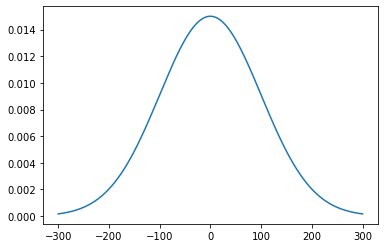

In [520]:
x = np.linspace(-300, 300, 1000)

plt.plot(x,gp.amplitude*np.exp(-0.5*(x/gp.length_scale)**2))

In [521]:
gp.amplitude =tfp.util.TransformedVariable(0.01, tfb.Exp(), dtype=tf.float64, name='amplitude')
gp.length_scale = tfp.util.TransformedVariable(
            100, tfb.Exp(), dtype=tf.float64, name='length_scale')
gp.kernel = psd_kernels.ExponentiatedQuadratic(
    gp.amplitude, gp.length_scale)
gp.observation_noise_variance = 0.

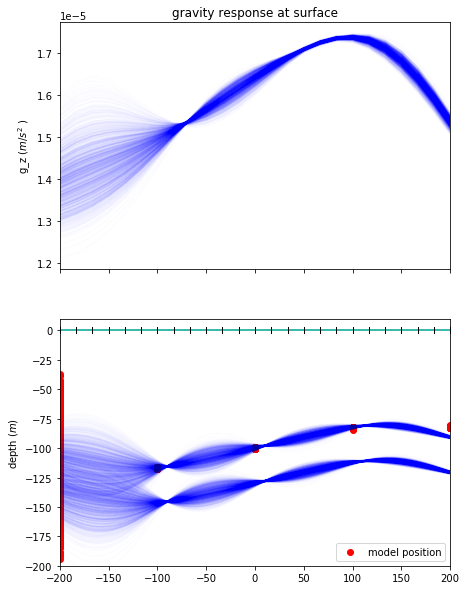

In [522]:
N = 1000
f,ax = plt.subplots(2,sharex=True, figsize = (7,10))
gravity_ = tf.TensorArray(tf.float64, size=N)

z_cord = tf.TensorArray(tf.float64, size=N)
for i in range(N):
    mu=mvn_prior.sample()
    if (mu.numpy() < 0).all():
        _x,_z = gp.GaussianProcess(control_index,mu,resolution=100)
        Draw(control_index,mu,_x,_z,R=Range[1],ax =ax,alpha = 0.01,color = 'b')  

        z_cord = z_cord.write(i,_z)
        gravity_ = gravity_.write(i,model.calculate_gravity(_x,_z))
    else: continue
x_cord = _x.numpy()

<b> Plotting</b>

In [523]:
def pdense(x, y, sigma,M=1000,midpoint = 0.2,lable=True, **kwargs):
    """ Plot probability density of y with known stddev sigma
    """
    assert len(x) == len(y) and len(x) == len(sigma)
    N = len(x)
    # TODO: better y ranging
    ymin, ymax = min(y - 2 * sigma), max(y + 2 * sigma)

    yy = np.linspace(ymin, ymax, M)[::-1]
    a = [np.exp(-((Y - yy) / s) ** 2) / s for Y, s in zip(y, sigma)]
    A = np.array(a)

    vmax, vmin = A.max(),A.min()
    num_levels = 3000

    levels = np.linspace(vmax, vmin, num_levels)[::-1]
    midp = np.mean(np.c_[levels[:-1], levels[1:]], axis=1)

    vals = np.interp(midp, [0, midpoint, vmax], [1, 0.3, 0])
    colors = plt.cm.gray(vals)
    cmap, norm = from_levels_and_colors(levels, colors)

    A = A.reshape(N, M)
    
    if 'ax' in kwargs:
        ax = kwargs.get('ax')
        fig = kwargs.get('f')
    else: fig, ax = plt.subplots()
    img = ax.imshow(A.T, cmap=cmap, aspect='auto',
               origin='upper',norm=norm ,extent=(min(x)[0], max(x)[0], ymin, ymax))
    ax.set_title('Density plot')
    if 'title' in kwargs:
        ax.set_title(kwargs.get('title'))
    if lable == True:

        v1 = np.round(np.linspace(A.min(), A.max(), 8, endpoint=True),2)
        cbar = fig.colorbar(img,ticks=v1,ax = ax)
        cbar.ax.set_ylabel('standard diviation')


In [524]:
x_cord_hf = x_cord[int(_x.shape[0]/2):]
z_cord_hf = np.squeeze(z_cord.stack())[:,int(_z.shape[0]/2):]


In [525]:
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


<Figure size 936x576 with 0 Axes>

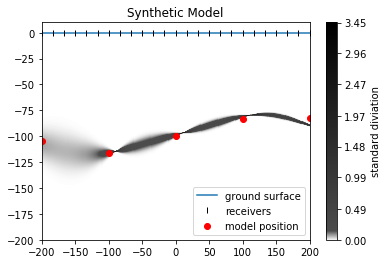

In [526]:
x = x_cord_hf[np.where((x_cord_hf>-200) & (x_cord_hf < 200))]
z = z_cord_hf[:,np.where((x_cord_hf>-200) & (x_cord_hf < 200))[0]]

# gravity = np.squeeze(gravity.stack())
x=np.expand_dims(x,1)
std = np.std(z,axis = 0)[::-1]
mean = np.mean(z,axis =0)[::-1]

y = np.expand_dims(mean,1)

std = np.expand_dims(std,1)

plt.figure(figsize=(13, 8))
pdense(x,y,std,M=10000,midpoint =0.15,title = 'Synthetic Model')

plt.scatter(control_index,mu, label = 'model position',c = 'red')
plt.plot(np.linspace(Range[0],Range[1],obs_N),np.zeros(obs_N), label = 'ground surface')
plt.plot(np.linspace(Range[0],Range[1],obs_N),np.zeros(obs_N),'k|',label = 'receivers')
plt.ylim(depth-100,10)
plt.xlim(Range[0],Range[1])
plt.legend(loc = 'lower right')

In [527]:
x_obv_p = np.expand_dims(x_obv,1)

In [528]:
gravity = np.squeeze(gravity_.stack())
gravity_mean = np.mean(gravity,0)
gravity_std = np.std(gravity,0)

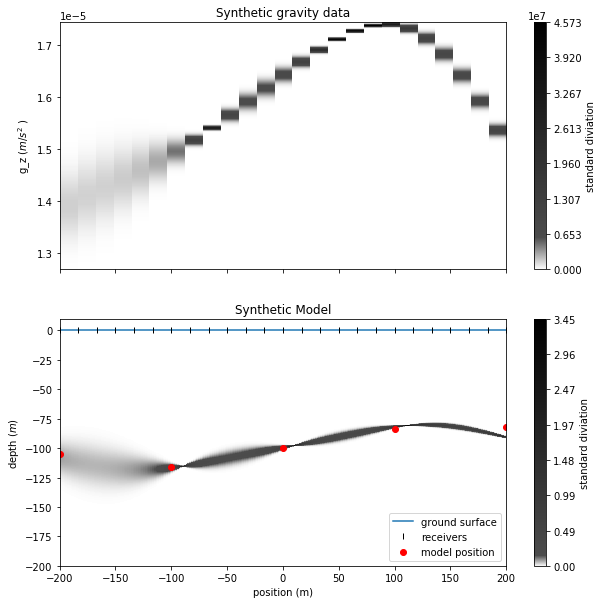

In [529]:
f,ax = plt.subplots(2,sharex=True, figsize = (10,10))

pdense(x,y,std,M=10000,midpoint =0.15,title = 'Synthetic Model',f = f, ax = ax[1])

ax[1].scatter(control_index,mu, label = 'model position',c = 'red')
ax[1].plot(np.linspace(Range[0],Range[1],obs_N),np.zeros(obs_N), label = 'ground surface')
ax[1].plot(np.linspace(Range[0],Range[1],obs_N),np.zeros(obs_N),'k|',label = 'receivers')
ax[1].set_ylim(depth-100,10)
ax[1].set_ylabel('depth ($m$)')
ax[1].set_xlabel('position (m)')
ax[1].set_xlim(Range[0],Range[1])
ax[1].legend(loc = 'lower right')

pdense(x_obv_p,gravity_mean,gravity_std,M=10000,midpoint = 0.6e7,title='Synthetic gravity data',f=f,ax=ax[0])
ax[0].set_ylabel('g_z ($m/s^2$ )')
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

# plt.savefig("/Users/zhouji/Documents/Presentations/EGU 2020/Presentation/Synthetic2D.png")

In [487]:
G = gravity

In [488]:
Data_mean = np.mean(G,0)

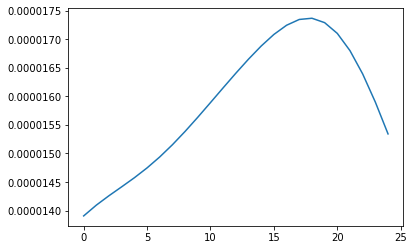

In [489]:
plt.plot(Data_mean)

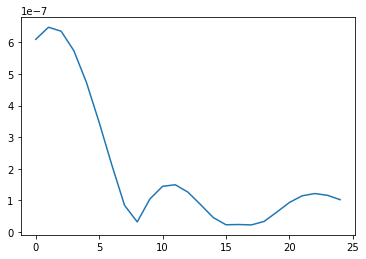

In [490]:
std = np.std(G,0)
plt.plot(std)

In [491]:
cov_matrix = np.cov(G.T)

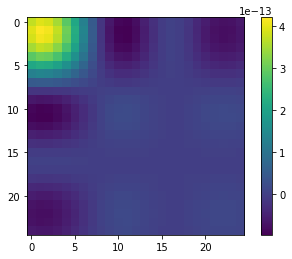

In [492]:
plt.imshow(cov_matrix)
plt.colorbar()

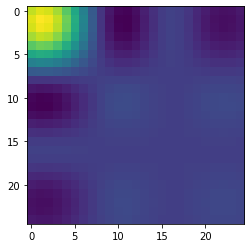

In [493]:
eigval,eigvec = np.linalg.eig(cov_matrix+cov_matrix.T.conj())

new_cov = eigvec@np.diag(eigval+1e-28)@eigvec.T

plt.imshow(new_cov)

With round off, this cov is positive definite

### Full covariance matrix

In [532]:
## define oversample parameter number
Number_para_os = 30

# prior
mu_prior = -100.*tf.ones([Number_para_os],dtype = tf.float64)
std_prior = 40
cov_prior = std_prior**2.*tf.eye(Number_para_os,dtype = tf.float64)

# likelihood
Data = tf.convert_to_tensor(Data_mean)
cov = tf.convert_to_tensor(new_cov,dtype = tf.float64)

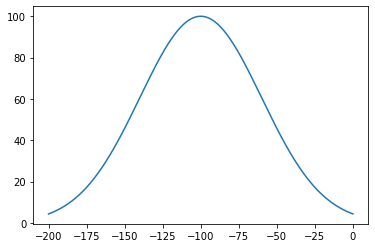

In [533]:
x = np.linspace(-200, 0, 1000)
plt.plot(x,-mu_prior[1]*np.exp(-0.5*((x+100)/std_prior)**2))

<b> Plot Prior </b>

In [534]:
prior_x = np.expand_dims(np.linspace(Range[0],Range[1],Number_para_os),1)
mu_prior_y = np.expand_dims(mu_prior,1)
cov_prior_sigma = np.expand_dims(std_prior*np.ones(Number_para_os),1)

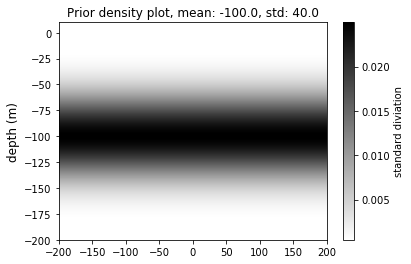

In [569]:
M = 1000
x,y,sigma=prior_x,mu_prior_y,cov_prior_sigma
assert len(x) == len(y) and len(x) == len(sigma)
N = len(x)
# TODO: better y ranging
ymin, ymax = min(y - 2 * sigma), max(y + 2 * sigma)

yy = np.linspace(ymin, ymax, M)
a = [np.exp(-((Y - yy) / s) ** 2) / s for Y, s in zip(y, sigma)]
A = np.array(a)

vmax, vmin = A.max(),A.min()
num_levels = 5000

levels = np.linspace(vmax, vmin, num_levels)
midp = np.mean(np.c_[levels[:-1], levels[1:]], axis=1)[::-1]
midpoint = np.mean([vmax,vmin])
vals = np.interp(midp, [vmin, midpoint, vmax], [1, 0.5, 0])
colors = plt.cm.gray(vals)
cmap, norm = from_levels_and_colors(levels, colors)



A = A.reshape(N, M)
fig, ax = plt.subplots()
ax.set_ylabel('depth (m)', fontsize=12)
ax.set_ylim(depth-100,10)
img = ax.imshow(A.T, cmap=cmap, aspect='auto',
           origin='lower' ,extent=(min(x)[0], max(x)[0],ymin, ymax))
ax.set_title('Prior density plot, mean: {}, std: {}'.format(y[0,0],cov_prior_sigma[0,0]))

cbar = fig.colorbar(img,ax = ax)
cbar.ax.set_ylabel('standard diviation')

plt.savefig("/Users/zhouji/Documents/Presentations/EGU 2020/Presentation/Input/Prior_polygon.png")

In [564]:
ymin, ymax

(array([-180.]), array([-20.]))

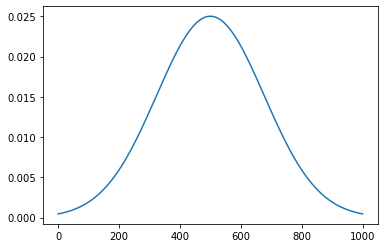

In [276]:
plt.plot(A[0])

<b> finding MAP </b>

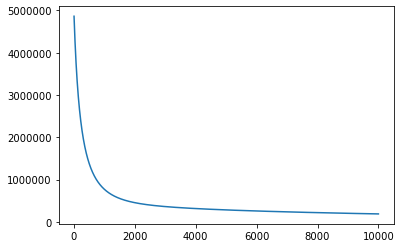

In [307]:

control_index_os = tf.linspace(Range[0],Range[1],Number_para_os)

True_position_sin = 20*tf.sin(0.01*control_index_os)+depth

model1 = Gravity_Polygon(obs_N,Range,rho,thickness,Number_para_os)

model1.set_prior(mu_prior,cov_prior,cov)

mu_init = tf.random.normal([Number_para_os],mean = depth, stddev = 20,seed = 1,dtype = tf.float64) # initial parameters

model1.gp = GaussianProcess2Dlayer(Range,depth,Number_para_os,thickness,)

model1.gp.amplitude =tfp.util.TransformedVariable(0.01, tfb.Exp(), dtype=tf.float64, name='amplitude')
model1.gp.length_scale = tfp.util.TransformedVariable(
            40, tfb.Exp(), dtype=tf.float64, name='length_scale')
model1.gp.kernel = psd_kernels.ExponentiatedQuadratic(
    model1.gp.amplitude, model1.gp.length_scale)
model1.gp.observation_noise_variance = 0.


model1.negative_log_posterior(Data,mu_init)

steps_gradient_decent = 10000
lost = []
mu = mu_init
for i in range(steps_gradient_decent):
    with tf.GradientTape() as t:  
        t.watch(mu)
        loss = model1.negative_log_posterior(Data,mu) # negative log posterior
        lost.append(loss.numpy())
    dlossdmu = t.gradient(loss,mu)
    if np.array(lost).size>1:
        if np.diff(lost[-2:])>150:
            learning_rate = 1e-7
        else:
            learning_rate = 1e-5
    mu = mu-tf.multiply(constant64(1e-7),dlossdmu)
plt.plot(lost)

In [331]:
_control_position = True_position_sin_os
mvn_prior = tfd.MultivariateNormalTriL(
    loc=model1.mu_prior,
    scale_tril=tf.linalg.cholesky(model1.cov_prior))
# define likelihood

_control_index = tf.linspace(
    model1.Range[0], model1.Range[1], tf.shape(_control_position)[0])

__x, __z = model1.gp.GaussianProcess(_control_index, _control_position)

Gm_ = model1.calculate_gravity(__x, __z)

mvn_likelihood = tfd.MultivariateNormalTriL(
    loc=Gm_,
    scale_tril=tf.linalg.cholesky(model1.cov))

# return the posterior probability
mvn_likelihood.log_prob(Data)

<tf.Tensor: shape=(), dtype=float64, numpy=-15869673.228553597>

In [332]:
_control_position1 = mu
mvn_prior = tfd.MultivariateNormalTriL(
    loc=model1.mu_prior,
    scale_tril=tf.linalg.cholesky(model1.cov_prior))
# define likelihood

_control_index = tf.linspace(
    model1.Range[0], model1.Range[1], tf.shape(_control_position1)[0])

__x, __z = model1.gp.GaussianProcess(_control_index, _control_position1)

Gm_1 = model1.calculate_gravity(__x, __z)

mvn_likelihood = tfd.MultivariateNormalTriL(
    loc=Gm_1,
    scale_tril=tf.linalg.cholesky(model1.cov))

# return the posterior probability
mvn_likelihood.log_prob(Data)

<tf.Tensor: shape=(), dtype=float64, numpy=-186638.45862724562>

In [342]:
np.sqrt(np.diag(model1.cov))

array([8.63003917e-07, 9.17254807e-07, 8.99470011e-07, 8.12158798e-07,
       6.68860427e-07, 4.90042258e-07, 2.98844292e-07, 1.18618974e-07,
       4.44363573e-08, 1.47478941e-07, 2.04095219e-07, 2.10950583e-07,
       1.77745645e-07, 1.21499103e-07, 6.37402705e-08, 3.15951219e-08,
       3.27101726e-08, 3.09351797e-08, 4.64317340e-08, 8.82091045e-08,
       1.31579342e-07, 1.61367555e-07, 1.71556359e-07, 1.63712191e-07,
       1.44032932e-07])

In [352]:
like_mu = []
like_true = []
for i in range(Data.shape[0]):
    m = Data[i]
    c = np.sqrt(np.diag(model1.cov))[i]
    normal = tfd.Normal(loc = m, scale=c)
    like_mu.append(normal.log_prob(Gm_1[i]).numpy())
    like_true.append(normal.log_prob(Gm_[i]).numpy())

In [357]:
print(np.array(like_mu).sum())
print(np.array(like_true).sum())

-1965.3560977198517
363.6433640200312


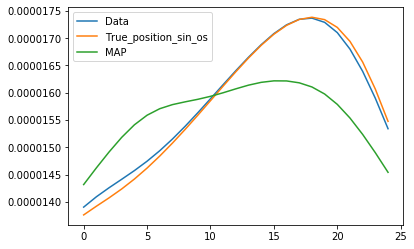

In [322]:
ax = plt.subplot()
ax.plot(Data,label = 'Data')
ax.plot(Gm_,label = 'True_position_sin_os')
ax.plot(Gm_1, label = 'MAP')
ax.legend()

In [364]:
mvn_likelihood = tfd.MultivariateNormalTriL(
            loc=Gm_,
            scale_tril=tf.linalg.cholesky(cov))
mvn_likelihood.log_prob(Data)

<tf.Tensor: shape=(), dtype=float64, numpy=-15869673.228553597>

In [368]:
diag_cov = np.diag(cov)*np.eye(25)
mvn_likelihood = tfd.MultivariateNormalTriL(
            loc=Gm_1,
            scale_tril=tf.linalg.cholesky(diag_cov))
mvn_likelihood.log_prob(Data)

<tf.Tensor: shape=(), dtype=float64, numpy=-1965.3560977198524>

<div class="alert alert-danger" role="alert">
    <b>The full covariance screw this likelihood function up entirely</b>

In [309]:
mvn_likelihood.log_prob(Data)

<tf.Tensor: shape=(), dtype=float64, numpy=-186638.45862724562>

In [286]:
model1.negative_log_posterior(Data,mu)

<tf.Tensor: shape=(), dtype=float64, numpy=227128.81634644966>

In [287]:
model1.negative_log_posterior(Data,True_position_sin_os)

<tf.Tensor: shape=(), dtype=float64, numpy=15869813.71969459>

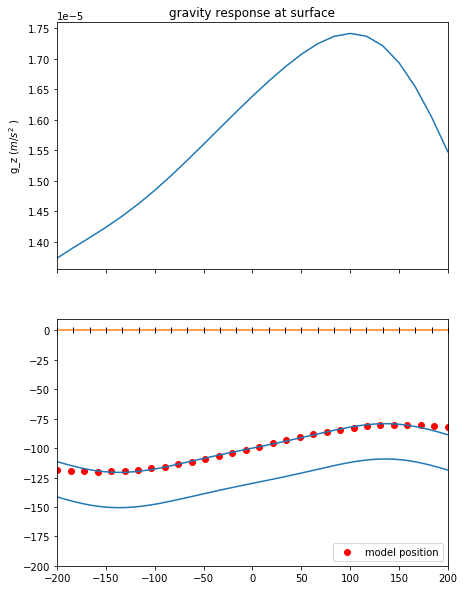

In [285]:
Draw(control_index_os,True_position_sin_os,R = Range[1])

In [281]:
gp.Number_para = Number_para_os

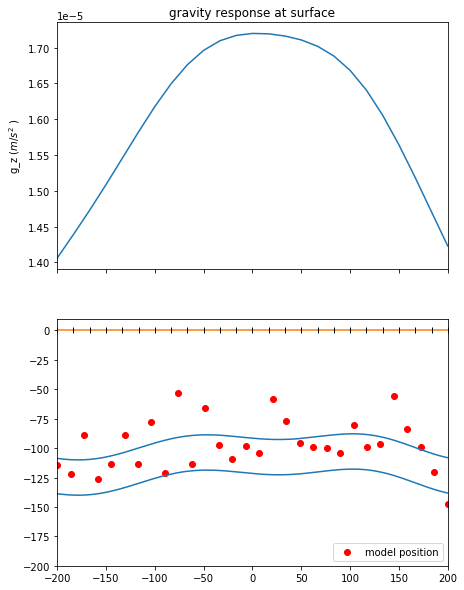

In [306]:
Draw(control_index_os,mu_init,R = Range[1])

In [58]:
True_position_sin_os = 20*tf.sin(0.01*control_index_os)+depth

In [48]:
MAP = mu

In [49]:
def Full_Hessian():
    Hess = tf.TensorArray(tf.float64, size=Number_para_os)
    for i in range(Number_para_os):
        with tf.GradientTape() as t:
            t.watch(MAP)
            with tf.GradientTape() as tt:
                tt.watch(MAP)
                loss = model1.negative_log_posterior(Data,MAP)
            jac = tt.gradient(loss,MAP,unconnected_gradients='zero')[i]
        hess = t.gradient(jac,MAP,unconnected_gradients = 'none')
        Hess = Hess.write(i,hess)
    return Hess.stack()
New_Hessian = Full_Hessian()

([<matplotlib.axis.XTick at 0x15a0f0588>,
 <a list of 5 Text xticklabel objects>)

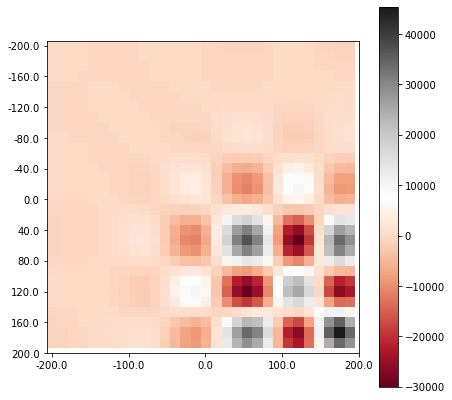

In [50]:
plt.figure(figsize=(7, 7))
plt.imshow(New_Hessian,plt.cm.RdGy)
plt.colorbar()
plt.yticks(np.linspace(0,New_Hessian.shape[0],11),np.linspace(Range[0],Range[1],11))
plt.xticks(np.linspace(0,New_Hessian.shape[0],5),np.linspace(Range[0],Range[1],5))

In [51]:
New_Hessian.shape

TensorShape([30, 30])

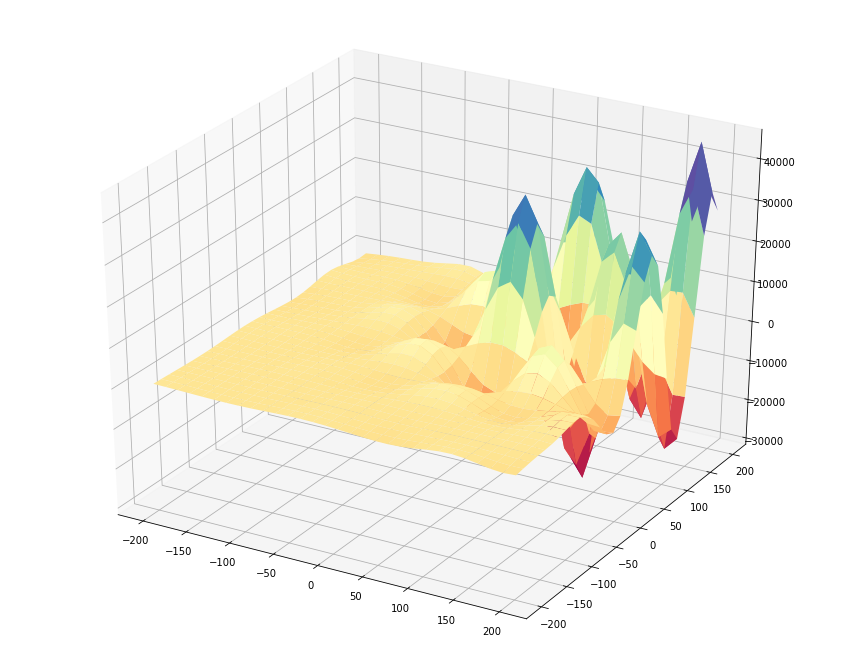

In [52]:
fig = plt.figure(figsize = (15,12))
ax = fig.gca(projection='3d')

X = np.linspace(-200,200,New_Hessian.shape[0])
Y = np.linspace(-200,200,New_Hessian.shape[0])
X, Y = np.meshgrid(X, Y)

surf = ax.plot_surface(X, Y, New_Hessian, cmap=plt.cm.Spectral,
                       linewidth=0, antialiased=True)

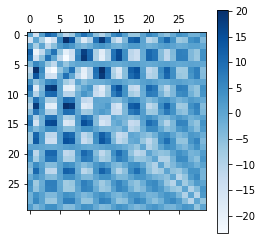

In [54]:
covariance = tf.linalg.inv(New_Hessian)
H = covariance.numpy()
for i in range(Number_para_os):
    H[i,i] = 0
plt.matshow(H,cmap=plt.cm.Blues)
plt.colorbar()

<header>
    <h2>MCMC</h2>
    <h3>RMH</h3>
</header>

In [55]:
number_sample=10000
number_burnin=0

In [56]:
num_results = number_sample
burnin = number_burnin


initial_chain_state = [
    depth * tf.ones([Number_para_os], dtype=tf.float64, name="init_t1"),
]

unnormalized_posterior_log_prob = lambda *args: model1.joint_log_post(Data,*args)

def gauss_new_state_fn(scale, dtype):
    gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
    def _fn(state_parts, seed):
        next_state_parts = []
        seed_stream  = tfp.util.SeedStream(seed, salt='RandomNormal')
        for sp in state_parts:
            next_state_parts.append(sp + gauss.sample(
            sample_shape=sp.shape, seed=seed_stream()))
        return next_state_parts
    return _fn

dtype = np.float64

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        new_state_fn=gauss_new_state_fn(scale=0.8, dtype=dtype)),
    num_burnin_steps=number_burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

/Users/zhouji/anaconda3/envs/nightly/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [57]:
accept_index = np.where(accepted==True)
accepted_samples_RMH = samples[accept_index]
accepted_samples_RMH = np.squeeze(accepted_samples_RMH)

Acceptance rate = 2.53%


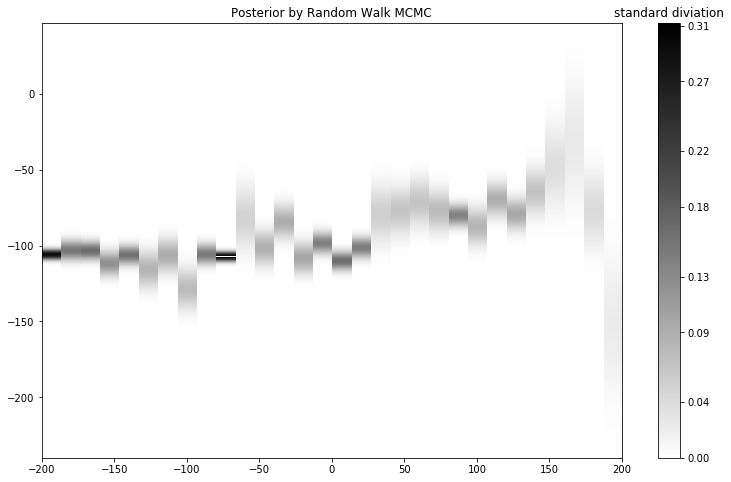

In [58]:
x_RMH = np.expand_dims(np.linspace(Range[0],Range[1],Number_para_os),1)
y_RMH = np.expand_dims(np.mean(accepted_samples_RMH,0),1)
std_RMH = np.expand_dims(np.std(accepted_samples_RMH,0),1)
pdense(x_RMH,y_RMH,std_RMH,M=10000,midpoint =0.2,title = 'Posterior by Random Walk MCMC')
print('Acceptance rate = %0.2f%%' % (100*accepted_samples_RMH.shape[0]/number_sample) )

In [ ]:
def simulated_gravity(x,z,x_obs=None,Number_=obs_N ,R=100,ax = None,style = None,**kwargs):
    """
    kwargs:
        x_obs: x coordinates of observation points
        Number_: number of observation points, if x_obs is not given
    return: 
        gravity: Tensor
    """
    if ax is None:
        f,ax=plt.subplots()
    if x_obs is None:
        x_obs = np.linspace(-R,R,Number_)
    y = np.zeros(np.shape(x_obs))
    obv = np.vstack((x_obs,y)).T

    gravity = model.calculate_gravity(x,z)
    if style is None:
        style = '-'
    ax.set_title('gravity response at surface')
    ax.set_ylabel('g_z ($m/s^2$ )')

    ax.set_xlim(-R,R)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    ax.plot(x_obs,gravity,style,**kwargs)
    return gravity

def Draw_inter(_control_index,_control_position,x_ = None, z_ = None, z_true = None,R = 100, ax = None,**kwargs):
    if ax is None:
        _,ax = plt.subplots(figsize = (14,7))
    if z_true is not None:
        ## true poistion is black
        ax.scatter(control_index,z_true, c = 'black',label = 'true position',alpha = 0.6)
    
    if x_ is None:
        x_,z_ = gp.GaussianProcess(_control_index,_control_position)
    ax.plot(x_,z_,**kwargs)
    ## proposal is red
    ax.scatter(_control_index,_control_position, label = 'model position',c = 'red')

    ax.plot(np.linspace(-R,R,obs_N),np.zeros(obs_N))
    ax.plot(np.linspace(-R,R,obs_N),np.zeros(obs_N),'k|')
    ax.set_ylim(depth-100,10)
    ax.set_xlim(-R,R)
    
def Draw(_control_index,_control_position,_x = None,_z = None,true_position = None,ax = None,R =100,**kwargs):
    if ax is None:
        f,ax = plt.subplots(2,sharex=True, figsize = (7,10))
    if _x is None:
        _x,_z = gp.GaussianProcess(_control_index,_control_position,resolution=10)

    simulated_gravity(_x,_z,R = R,ax = ax[0],**kwargs)
    Draw_inter(_control_index,_control_position,x_ = _x, z_ = _z,R = R,ax = ax[1],z_true =true_position,**kwargs)
#     plt.legend(loc = 'lower right')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),loc = 'lower right')
    
Draw(control_index,True_position_sin,R=Range[1],alpha = 0.1,color = 'b')

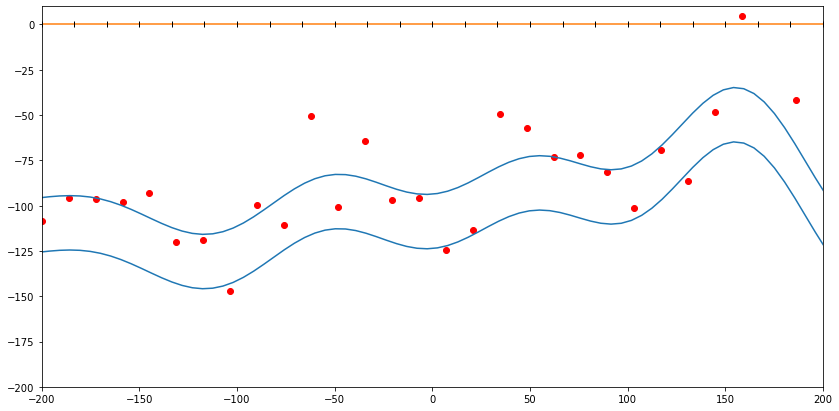

In [93]:
Draw_inter(_control_index,_control_position,R = 200)

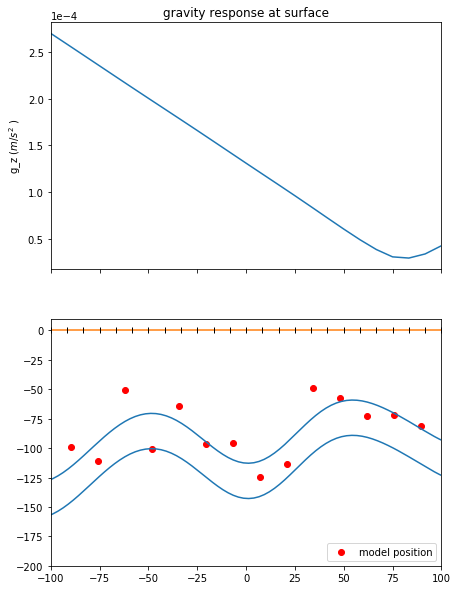

In [69]:
Draw(control_index_os,accepted_samples_RMH[-1])

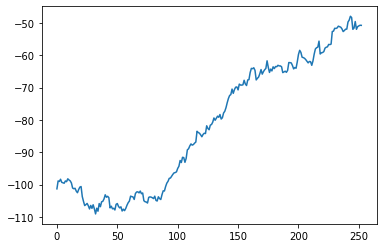

In [68]:
plt.plot(accepted_samples_RMH[:,10])

In [49]:
import pandas as pd

<header> 
    <h3>HMC</h3>
</header>

In [82]:
number_sample=20000
number_burnin=0

In [ ]:
@tf.function
def run_HMC():
    samples, kernel_results = tfp.mcmc.sample_chain(
        num_results=number_sample,
        current_state=initial_chain_state,
        kernel=tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn = unnormalized_posterior_log_prob,
        step_size = 1e-4, max_tree_depth=10, max_energy_diff=100.0,
        unrolled_leapfrog_steps=1, parallel_iterations=1, seed=None, name=None
    ),
        num_burnin_steps=number_burnin,
        num_steps_between_results=1,  # Thinning.
        parallel_iterations=1)
    return samples,kernel_results

samples,kernel_results = run_HMC()

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

accept_index = np.where(accepted==True)
accepted_samples_HMC = samples[accept_index]
accepted_samples_HMC = np.squeeze(accepted_samples_HMC)


/Users/zhouji/anaconda3/envs/nightly/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [ ]:
@tf.function
def run_HMC():
    samples, kernel_results = tfp.mcmc.sample_chain(
        num_results=number_sample,
        current_state=initial_chain_state,
        kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_posterior_log_prob,
            step_size = 9e-4,
            num_leapfrog_steps = 3),
        num_burnin_steps=number_burnin,
        num_steps_between_results=5,  # Thinning.
        parallel_iterations=1)
    return samples,kernel_results

samples,kernel_results = run_HMC()

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

accept_index = np.where(accepted==True)
accepted_samples_HMC = samples[accept_index]
accepted_samples_HMC = np.squeeze(accepted_samples_HMC)


In [ ]:
x_HMC = np.expand_dims(np.linspace(Range[0],Range[1],Number_para_os),1)
y_HMC = np.expand_dims(np.mean(accepted_samples_HMC,0),1)
std_HMC = np.expand_dims(np.std(accepted_samples_HMC,0),1)
pdense(x_HMC,y_HMC,std_HMC,M=10000,midpoint =0.2,title = 'Posterior by Random Walk MCMC')
print('HMC Acceptance rate = %0.2f%%' % (100*accepted_samples_HMC.shape[0]/number_sample) )

In [ ]:
plt.plot(accepted_samples_HMC[:,9])

In [69]:
num_results

100000

In [ ]:
MAP

#### oversample

In [ ]:
## define oversample parameter number
Number_para_os = 50

In [ ]:
# prior
mu_prior = -100.*tf.ones([Number_para_os],dtype = tf.float64)
cov_prior = 15.*tf.eye(Number_para_os,dtype = tf.float64)


# likelihood
Data = tf.convert_to_tensor(Data_mean)
# cov = tf.convert_to_tensor(cov_matrix,dtype = tf.float64)
cov = tf.convert_to_tensor(std**2)*tf.eye(obs_N,dtype=tf.float64)

In [ ]:
control_index_os = tf.linspace(Range[0],Range[1],Number_para_os)

True_position_sin = 20*tf.sin(0.01*control_index_os)+depth

In [ ]:
model1 = Gravity_Polygon(obs_N,Range,rho,thickness,Number_para_os)

In [ ]:
model1.set_prior(mu_prior,cov_prior,cov)

In [ ]:
mu_init = tf.random.normal([Number_para_os],mean = depth, stddev = 20,seed = 1,dtype = tf.float64) # initial parameters

In [ ]:
model1.gp = GaussianProcess2Dlayer(Range,depth,Number_para_os,thickness,)

In [ ]:
model1.negative_log_posterior(Data,mu_init)

In [ ]:
steps_gradient_decent = 1000
lost = []
mu = mu_init
for i in range(steps_gradient_decent):
    with tf.GradientTape() as t:  
        t.watch(mu)
        loss = model1.negative_log_posterior(Data,mu) # negative log posterior
        lost.append(loss.numpy())
    dlossdmu = t.gradient(loss,mu)
    mu = mu-tf.multiply(constant64(0.1),dlossdmu)
plt.plot(lost)

In [ ]:
plt.plot(Data_mean)

In [ ]:
plt.plot(mu)

In [ ]:
MAP = mu

In [ ]:
def Full_Hessian():
    Hess = tf.TensorArray(tf.float64, size=Number_para_os)
    j=0
    for i in range(Number_para_os):
        with tf.GradientTape() as t:
            t.watch(MAP)
            with tf.GradientTape() as tt:
                tt.watch(MAP)
                loss = model1.negative_log_posterior(Data,MAP)
            jac = tt.gradient(loss,MAP,unconnected_gradients='zero')[i]
        hess = t.gradient(jac,MAP,unconnected_gradients = 'none')
        Hess = Hess.write(j,hess)
        j = j+1
    return Hess.stack()
New_Hessian = Full_Hessian()

In [ ]:
plt.imshow(New_Hessian)

In [ ]:
covariance = tf.linalg.inv(New_Hessian)
H = covariance.numpy()
for i in range(Number_para_os):
    H[i,i] = 0
plt.matshow(H,cmap=plt.cm.Blues)
plt.colorbar()

# Model 2

In [ ]:
depth = -110
Number_para = 5
control_index = tf.linspace(Range[0],Range[1],Number_para)
gp = GaussianProcess2Dlayer(Range,depth,Number_para,thickness,)
True_position_sin = 20*tf.sin(0.01*control_index)+depth

# prior
mu_prior = True_position_sin
cov_prior = tf.constant([15**2,0.1,0.1,0.1,8**2],dtype = tf.float64)*tf.eye(Number_para,dtype = tf.float64)

x_obv = tf.linspace(Range[0],Range[1],obs_N)

rho = 2000
# likelihood
sig_e = constant64(2*1e-8)
cov = sig_e**2.*tf.eye(obs_N,dtype = tf.float64)


model = Gravity_Polygon(obs_N,Range,rho,thickness,Number_para)

mvn_prior = tfd.MultivariateNormalTriL(
    loc=mu_prior,
    scale_tril=tf.linalg.cholesky(cov_prior))

control_index_ = tf.expand_dims(tf.linspace(Range[0],Range[1],Number_para),1)


gp.amplitude =tfp.util.TransformedVariable(0.01, tfb.Exp(), dtype=tf.float64, name='amplitude')
gp.length_scale = tfp.util.TransformedVariable(
            45, tfb.Exp(), dtype=tf.float64, name='length_scale')
gp.kernel = psd_kernels.ExponentiatedQuadratic(
    gp.amplitude, gp.length_scale)
gp.observation_noise_variance = tfp.util.TransformedVariable(0., tfb.Exp(), dtype=tf.float64, name='noise_variance')

N = 1000
f,ax = plt.subplots(2,sharex=True, figsize = (7,10))
gravity = tf.TensorArray(tf.float64, size=N)
for i in range(N):
    mu=mvn_prior.sample()
    if (mu.numpy() < 0).all():
        Draw(control_index,mu,R=Range[1],ax =ax,alpha = 0.1,color = 'b')
        _x,_z = gp.GaussianProcess(control_index,mu)
        gravity = gravity.write(i,model.calculate_gravity(_x,_z))
    else: continue

G = gravity.stack().numpy()

Data_mean = np.mean(G,0)

std = np.std(G,0)


In [ ]:
cov_matrix = np.cov(G.T)

In [ ]:
plt.imshow(cov_matrix)

In [ ]:
eigval,eigvec = np.linalg.eig(cov_matrix+cov_matrix.T.conj())
new_cov = eigvec@np.diag(eigval+1e-28)@eigvec.T

<b> Problem: </b> covariance is not positive-definite? 

In [ ]:
#### oversample

## define oversample parameter number
Number_para_os = 50

# prior
mu_prior = -100.*tf.ones([Number_para_os],dtype = tf.float64)
cov_prior = 15.*tf.eye(Number_para_os,dtype = tf.float64)


# likelihood
Data = tf.convert_to_tensor(Data_mean)
# cov = tf.convert_to_tensor(cov_matrix,dtype = tf.float64)
cov = tf.convert_to_tensor(std**2)*tf.eye(obs_N,dtype=tf.float64)

control_index_os = tf.linspace(Range[0],Range[1],Number_para_os)

True_position_sin = 20*tf.sin(0.01*control_index_os)+depth

model1 = Gravity_Polygon(obs_N,Range,rho,thickness,Number_para_os)

model1.set_prior(mu_prior,cov_prior,cov)

mu_init = tf.random.normal([Number_para_os],mean = depth, stddev = 20,seed = 1,dtype = tf.float64) # initial parameters

model1.gp = GaussianProcess2Dlayer(Range,depth,Number_para_os,thickness,)



steps_gradient_decent = 1000
lost = []
mu = mu_init
for i in range(steps_gradient_decent):
    with tf.GradientTape() as t:  
        t.watch(mu)
        loss = model1.negative_log_posterior(Data,mu) # negative log posterior
        lost.append(loss.numpy())
    dlossdmu = t.gradient(loss,mu)
    mu = mu-tf.multiply(constant64(0.1),dlossdmu)
plt.plot(lost)
MAP = mu


In [ ]:
def Full_Hessian():
    Hess = tf.TensorArray(tf.float64, size=Number_para_os)
    j=0
    for i in range(Number_para_os):
        with tf.GradientTape() as t:
            t.watch(MAP)
            with tf.GradientTape() as tt:
                tt.watch(MAP)
                loss = model1.negative_log_posterior(Data,MAP)
            jac = tt.gradient(loss,MAP,unconnected_gradients='zero')[i]
        hess = t.gradient(jac,MAP,unconnected_gradients = 'none')
        Hess = Hess.write(j,hess)
        j = j+1
    return Hess.stack()
New_Hessian = Full_Hessian()

New_Hessian

covariance = tf.linalg.inv(New_Hessian)
H = covariance.numpy()
for i in range(Number_para_os):
    H[i,i] = 0
plt.matshow(H,cmap=plt.cm.RdGy)
plt.colorbar()

Large Hessian == small covariance == low uncertainty

In [ ]:
plt.plot(np.diag(New_Hessian))

In [ ]:
New_Hessian += New_Hessian.numpy().T.conj()
eigval,eigvec = np.linalg.eigh(New_Hessian)

In [ ]:
plt.imshow(New_Hessian)

<b> with new covariance </b>

In [ ]:
#### oversample

## define oversample parameter number
Number_para_os = 50

# prior
mu_prior = -100.*tf.ones([Number_para_os],dtype = tf.float64)
cov_prior = 15.*tf.eye(Number_para_os,dtype = tf.float64)


# likelihood
Data = tf.convert_to_tensor(Data_mean)
# cov = tf.convert_to_tensor(cov_matrix,dtype = tf.float64)
cov = new_cov

control_index_os = tf.linspace(Range[0],Range[1],Number_para_os)

True_position_sin = 20*tf.sin(0.01*control_index_os)+depth

model1 = Gravity_Polygon(obs_N,Range,rho,thickness,Number_para_os)

model1.set_prior(mu_prior,cov_prior,cov)

mu_init = tf.random.normal([Number_para_os],mean = depth, stddev = 20,seed = 1,dtype = tf.float64) # initial parameters

model1.gp = GaussianProcess2Dlayer(Range,depth,Number_para_os,thickness,)



steps_gradient_decent = 1000
lost = []
mu = mu_init
for i in range(steps_gradient_decent):
    with tf.GradientTape() as t:  
        t.watch(mu)
        loss = model1.negative_log_posterior(Data,mu) # negative log posterior
        lost.append(loss.numpy())
    dlossdmu = t.gradient(loss,mu)
    mu = mu-tf.multiply(constant64(1e-5),dlossdmu)
plt.plot(lost)
MAP = mu


In [ ]:
New_Hessian2 = Full_Hessian()


covariance = tf.linalg.inv(New_Hessian2)
H = covariance.numpy()
for i in range(Number_para_os):
    H[i,i] = 0
plt.matshow(H,cmap=plt.cm.RdGy)
plt.colorbar()

In [ ]:
x = np.linspace(-300, 300, 1000)

plt.plot(x,gp.amplitude*np.exp(-0.5*(x/gp.length_scale)**2))

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(New_Hessian2,plt.cm.RdGy)
plt.colorbar()
plt.yticks(np.linspace(0,50,11),np.linspace(-100,100,11))
plt.xticks(np.linspace(0,50,5),np.linspace(-100,100,5))

In [ ]:

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.arange(-100, 100, 4)
Y = np.arange(-100, 100, 4)
X, Y = np.meshgrid(X, Y)

surf = ax.plot_surface(X, Y, New_Hessian2, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

###  TODO: gradient decent
 - Nelder–Mead method
 - Broyden–Fletcher–Goldfarb–Shanno algorithm

In [ ]:
steps_gradient_decent = 5000
lost = []
for i in range(steps_gradient_decent):
    with tf.GradientTape() as t:  
        t.watch(mu)
        loss = model.negative_log_posterior(Data,mu) # negative log posterior
        lost.append(loss.numpy())
        dlossdmu = t.gradient(loss,mu)
        print('mu',mu.numpy())
        print('loss',loss.numpy())
        print('dmu',dlossdmu.numpy())
    mu = mu-tf.multiply(constant64(0.0001),dlossdmu)
plt.plot(lost)
MAP = mu

In [ ]:
Draw(control_index,MAP, True_position_sin)

## SVGD

In [ ]:
def svgd_kernel(X0):
    XY = tf.matmul(X0, tf.transpose(X0))
    X2_ = tf.reduce_sum(tf.square(X0), axis=1)

    x2 = tf.reshape(X2_, shape=(tf.shape(X0)[0], 1))

    X2e = tf.tile(x2, [1, tf.shape(X0)[0]])
    
    ## (x1 -x2)^2 + (y1 -y2)^2
    H = tf.subtract(tf.add(X2e, tf.transpose(X2e)), 2 * XY)

    V = tf.reshape(H, [-1, 1])

    # median distance
    def get_median(v):
        v = tf.reshape(v, [-1])
        m = v.get_shape()[0]//2
        return tf.nn.top_k(v, m).values[m-1]
    h = get_median(V)
    h = tf.sqrt(
        0.5 * h / tf.math.log(tf.cast(tf.shape(X0)[0], tf.float64) + 1.0))

    # compute the rbf kernel
    Kxy = tf.exp(-H / h ** 2 / 2.0)

    dxkxy = tf.negative(tf.matmul(Kxy, X0))
    sumkxy = tf.expand_dims(tf.reduce_sum(Kxy, axis=1), 1)
    dxkxy = tf.add(dxkxy, tf.multiply(X0, sumkxy)) / (h ** 2)

    return (Kxy, dxkxy)

In [ ]:
lr = constant64(0.004)
num_iter = 5000
num_particles = 200

In [ ]:
mu = tf.random.uniform([num_particles,Number_para],-200,-20,dtype = tf.float64)
_,ax = plt.subplots(figsize = (14,7))
ax.plot(x,mu,'k.')
Draw_inter(control_index,True_position_sin,ax=ax)

In [ ]:
import seaborn as sns
sns.kdeplot(mu[:,0].numpy(),label = '1')
sns.kdeplot(mu[:,1].numpy(),label = '2')
sns.kdeplot(mu[:,2].numpy(),label = '3')
sns.kdeplot(mu[:,3].numpy(),label = '4')
sns.kdeplot(mu[:,4].numpy(),label = '5')

In [ ]:
def gradient(mu):
    log_p_grad = tf.TensorArray(tf.float64, size=num_particles)
    for i in range(mu.shape[0]):
        with tf.GradientTape() as t:
            t.watch(mu)
            f = model.joint_log_post(Data,mu[i])
        log_p_grad =log_p_grad.write(i, t.gradient(f,mu)[i])
    return log_p_grad.stack()

In [ ]:
x = np.linspace(Range[0],Range[1],Number_para)
x = np.reshape(np.tile(x,num_particles),[num_particles,Number_para])

In [ ]:
@tf.function
def svgd_one_iter(mu):
    log_p_grad = gradient(mu)
    kernel_matrix, kernel_gradients = svgd_kernel(mu)
    grad_theta = (tf.matmul(kernel_matrix, log_p_grad) + kernel_gradients)/num_particles
    mu = mu+lr*grad_theta
    return mu

def run_chain_svgd(mu):
    for i in range(num_iter):
        mu = svgd_one_iter(mu)
    return mu

In [ ]:
mu = run_chain_svgd(mu)

In [ ]:
 _,ax = plt.subplots(figsize = (14,7))
ax.plot(x,mu,'k.')
Draw_inter(control_index,True_position_sin,ax=ax)

In [ ]:
import seaborn as sns
sns.kdeplot(mu[:,0].numpy(),label = '1')
sns.kdeplot(mu[:,1].numpy(),label = '2')
sns.kdeplot(mu[:,2].numpy(),label = '3')
sns.kdeplot(mu[:,3].numpy(),label = '4')
sns.kdeplot(mu[:,4].numpy(),label = '5')
